This file is part of Estimation of Causal Effects in the Alzheimer's Continuum (Causal-AD).

Causal-AD is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

Causal-AD is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with Causal-AD. If not, see <https://www.gnu.org/licenses/>.

# Step 3: Compare Effects

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from causalad.coef_plot import rename_coef, Plotter

In [2]:
def read_coef(filename):
    coef = pd.read_csv(filename, index_col=0).drop("mean_PPD")
    if "AGE" in coef.index:
        coef.drop("AGE", inplace=True)
    coef = coef.loc[~coef.index.str.startswith("Deconf_")]
    coef.index = coef.index.map(rename_coef)
    coef = coef.stack().rename_axis(["coef", "variable"]).rename("value").reset_index()
    return coef

def read_all_coef(base_dir):
    data = pd.concat((
        read_coef(base_dir / "coef_bpmf.csv").assign(method="BPMF"),
        read_coef(base_dir / "coef_ppca.csv").assign(method="PPCA"),
        read_coef(base_dir / "coef_regout.csv").assign(method="Regress Out"),
        read_coef(base_dir / "coef_noconf.csv").assign(method="Non-Causal")
    ))
    mask = data.coef.str.endswith('(Intercept)')
    data = data.loc[~mask]
    return data

def coef_load_plot_and_save(base_dir):
    data = read_all_coef(base_dir)

    coefs = (
        data
        .query("(variable == 'mean') & (method == 'Non-Causal')")
        .set_index("coef")
        .loc[:, "value"]
        .sort_values()
    )

    n_coefs = coefs.shape[0]
    width = n_coefs * 0.6
    
    palette = [
        (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),  # red
        (0.596078431372549, 0.3058823529411765, 0.6392156862745098),     # purple
        (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),  # blue
        (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),   # green
    ]
    
    method_order = ["Non-Causal", "Regress Out", "PPCA", "BPMF"]

    p = Plotter(
        coef_order=coefs.index.tolist(),
        method_order=method_order,
        palette=palette,
        figsize=(width, 5)
    )
    p.plot(data)

    fig_path = base_dir / f"coef-{p.orient}.pdf"
    plt.savefig(fig_path, bbox_inches="tight", pad_inches=0.0)
    return fig_path.resolve()

PosixPath('/notebooks/data/outputs/adni/dim6/coef-horizontal.pdf')

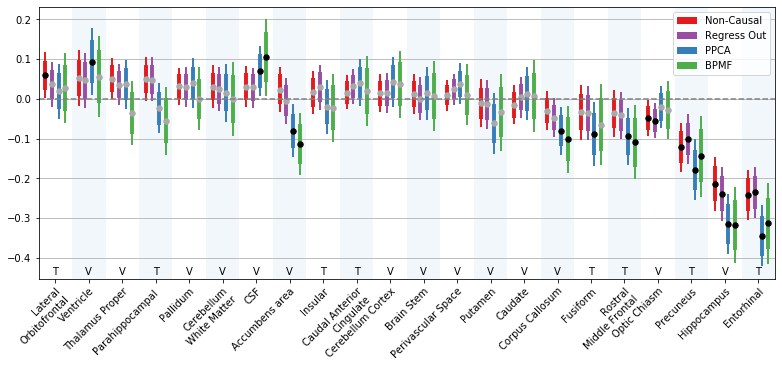

In [3]:
coef_load_plot_and_save(
    Path("data/outputs/adni/dim6/")
)